In [ ]:
# pytorch
import torch

# torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms


# torchinfo
%pip install torchinfo
%pip install torchmetrics

# standard data handling
import os

# system
import pathlib
import zipfile
from pathlib import Path

# timing and printing
# plotting
import matplotlib.pyplot as plt
import numpy as np
import requests

# image
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
# make device agnostic code (default is cpu)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Available device is: {device}")

Available device is: cpu


In [ ]:
# filenames
filenames = {
    "pytorch_helper_functions.py": "https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/pytorch_helper_functions.py",
    "training.py": "https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/training.py",
    "make_predictions.py": "https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/make_predictions.py",
    "validation.py": "https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/validation.py",
    "visualizing_images.py": "https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/visualizing_images.py",
}

for filename, file_path in filenames.items():
    # download helper functions from repo
    if Path(filename).is_file():
        print(f"{filename} already exists. Skipping download")

    else:
        request = requests.get(file_path)
        with open(filename, "wb") as f:
            f.write(request.content)

        print(f"Downloaded {filename}.")

Downloaded pytorch_helper_functions.py.
Downloaded training.py.
Downloaded make_predictions.py.
Downloaded validation.py.
Downloaded visualizing_images.py.


In [ ]:
# setup path to data folder
data_path = Path("data/")
image_path = data_path / "ML2-Dataset"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exists. Skipping dowload.")
else:
    print(f"Did not find {image_path} directory, creating one.")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "ML2-Dataset.zip", "wb") as f:
        request = requests.get(
            "https://bwsyncandshare.kit.edu/s/ABCDfTbtTnETgFT/download/ML2-Dataset.zip",
        )
        print("Downloading the data.")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "ML2-Dataset.zip", "r") as zip_ref:
        print("Unzipping the data.")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "ML2-Dataset.zip")

data/ML2-Dataset directory already exists. Skipping dowload.


In [160]:
# due to the structure of the data the image path has to be adjusted
image_path = image_path / "student_dataset"

# set the training and val paths
train_dir = image_path / "train"
val_dir = image_path / "test_angvel"
test_dir = image_path / "test_color"

# print
print(f"Train Path: {train_dir} | Val Path: {val_dir}| Val Path: {test_dir}")

Train Path: data/ML2-Dataset/student_dataset/train | Val Path: data/ML2-Dataset/student_dataset/test_angvel| Val Path: data/ML2-Dataset/student_dataset/test_color


In [ ]:
# Write transform for image input
data_transform_X = transforms.Compose(
    [
        # Keep it simple first: Resize the images to 224X224 pizels
        transforms.Resize(size=(224, 224)),
        # convert images to grayscale: https://pytorch.org/vision/stable/generated/torchvision.transforms.Grayscale.html#torchvision.transforms.Grayscale
        transforms.Grayscale(3),
        # Turn the image into a torch.Tensor, this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
        transforms.ToTensor(),
    ],
)

# Write transform for image desired output
data_transform_y = transforms.Compose(
    [
        # Keep it simple first: Resize the images to 224X224 pizels
        transforms.Resize(size=(224, 224)),
        # Turn the image into a torch.Tensor, this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
        transforms.ToTensor(),
    ],
)

# Write transform for image desired output
data_transform_test = transforms.Compose(
    [
        # Keep it simple first: Resize the images to 224X224 pizels
        transforms.Resize(size=(224, 224)),
        # convert images to grayscale: https://pytorch.org/vision/stable/generated/torchvision.transforms.Grayscale.html#torchvision.transforms.Grayscale
        transforms.Grayscale(3),
        # Turn the image into a torch.Tensor, this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
        transforms.ToTensor(),
    ],
)

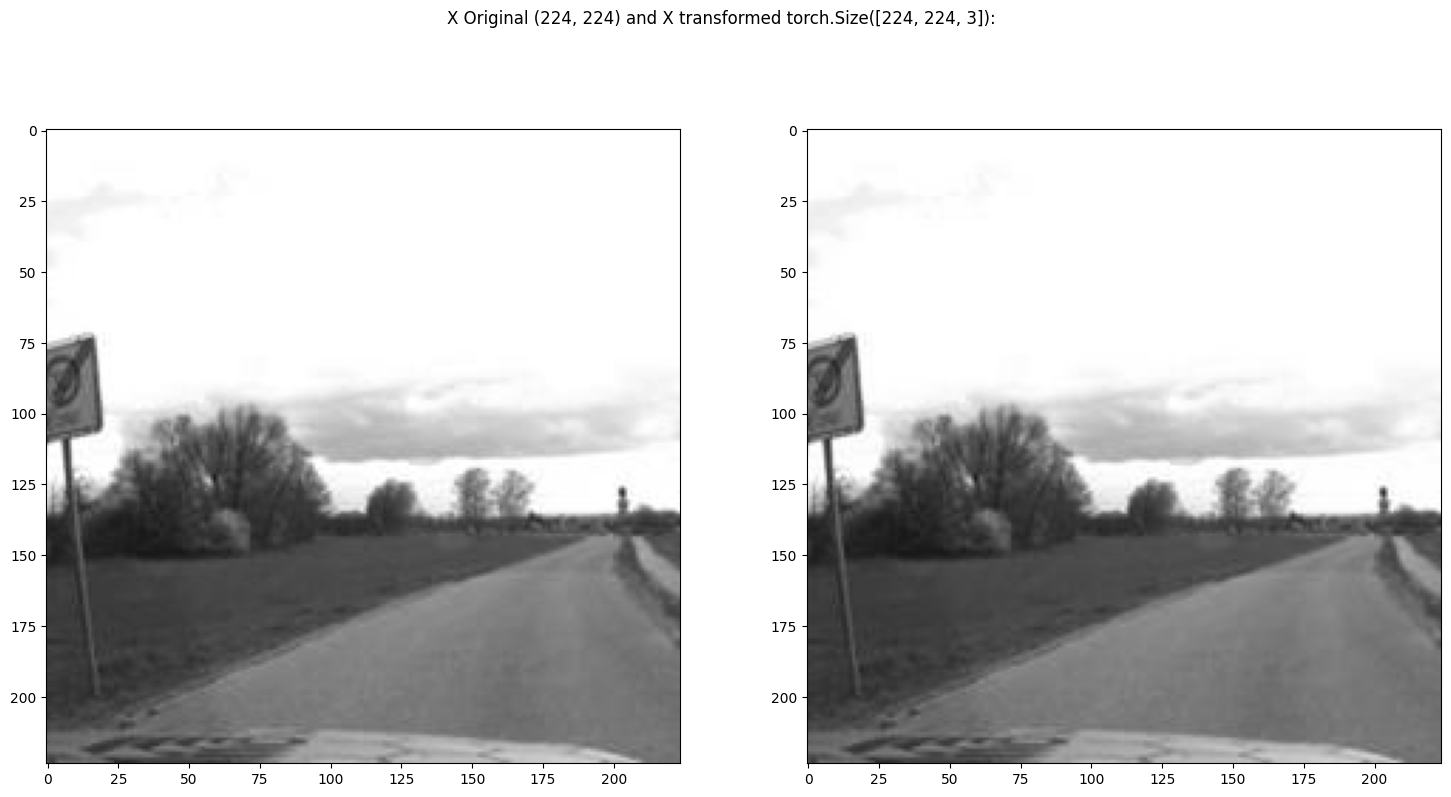

In [ ]:
PATH = "/content/data/ML2-Dataset/student_dataset/test_color/images/2_0000.jpg"

# open and plot the image
with Image.open(PATH) as img:
    # plot image and label image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    transformed_image = data_transform_test(img).permute(1, 2, 0)
    fig.suptitle(f"X Original {img.size} and X transformed {transformed_image.shape}:")
    ax1.imshow(img, cmap="gray", vmin=0, vmax=255)
    ax2.imshow(transformed_image)


In [ ]:
class OwnDataset(Dataset):
    """
    All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented.
    """

    def __init__(self, root: str, transform=None, target_transform=None):
        """This function is mandatory and initializes the dataset"""
        # Get all image paths
        self.paths = sorted(list(pathlib.Path(root).glob("*/*.jpg")))
        # Setup transforms
        self.transform = transform
        self.target_transform = target_transform

    def load_image(self, index: int):
        """This function opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        """This function is mandatory and returns the size of the dataset"""
        return len(self.paths)

    def __getitem__(self, index: int):
        """This function is mandatory and returns a sample of the dataset"""
        # Select sample
        img = self.load_image(index)

        # Transform if necessary
        if self.transform and self.target_transform:
            return self.transform(img), self.target_transform(img)
        return img, img

In [ ]:
# Use OwnDataset to create train dataset
train_data = OwnDataset(
    root=train_dir,
    transform=data_transform_X,
    target_transform=data_transform_y,
)

# Use OwnDataset to create validation dataset
val_data = OwnDataset(
    root=val_dir,
    transform=data_transform_X,
    target_transform=data_transform_y,
)

# Use OwnDataset to create validation dataset
test_data = OwnDataset(
    root=test_dir,
    transform=data_transform_test,
    target_transform=data_transform_test,
)

print(
    f"Train data length: {len(train_data)} | Val data length: {len(val_data)} | Test data length: {len(test_data)}",
)

Train data length: 5656 | Val data length: 1638 | Test data length: 50


In [ ]:
# batch size hyperparameter
BATCH_SIZE = 32

# construct mini batches for the train and test data
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

# check the dimensions
print(
    f"Length of the train DataLoader: {len(train_dataloader)} batches of {BATCH_SIZE}. (Orignially {len(train_data)})",
)
print(
    f"Length of the val DataLoader: {len(val_dataloader)} batches of {BATCH_SIZE}.  (Orignially {len(val_data)})",
)
print(
    f"Length of the test DataLoader: {len(test_dataloader)} batches of {1}.  (Orignially {len(test_data)})",
)

Length of the train DataLoader: 177 batches of 32. (Orignially 5656)
Length of the val DataLoader: 52 batches of 32.  (Orignially 1638)
Length of the test DataLoader: 50 batches of 1.  (Orignially 50)


Batch shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]


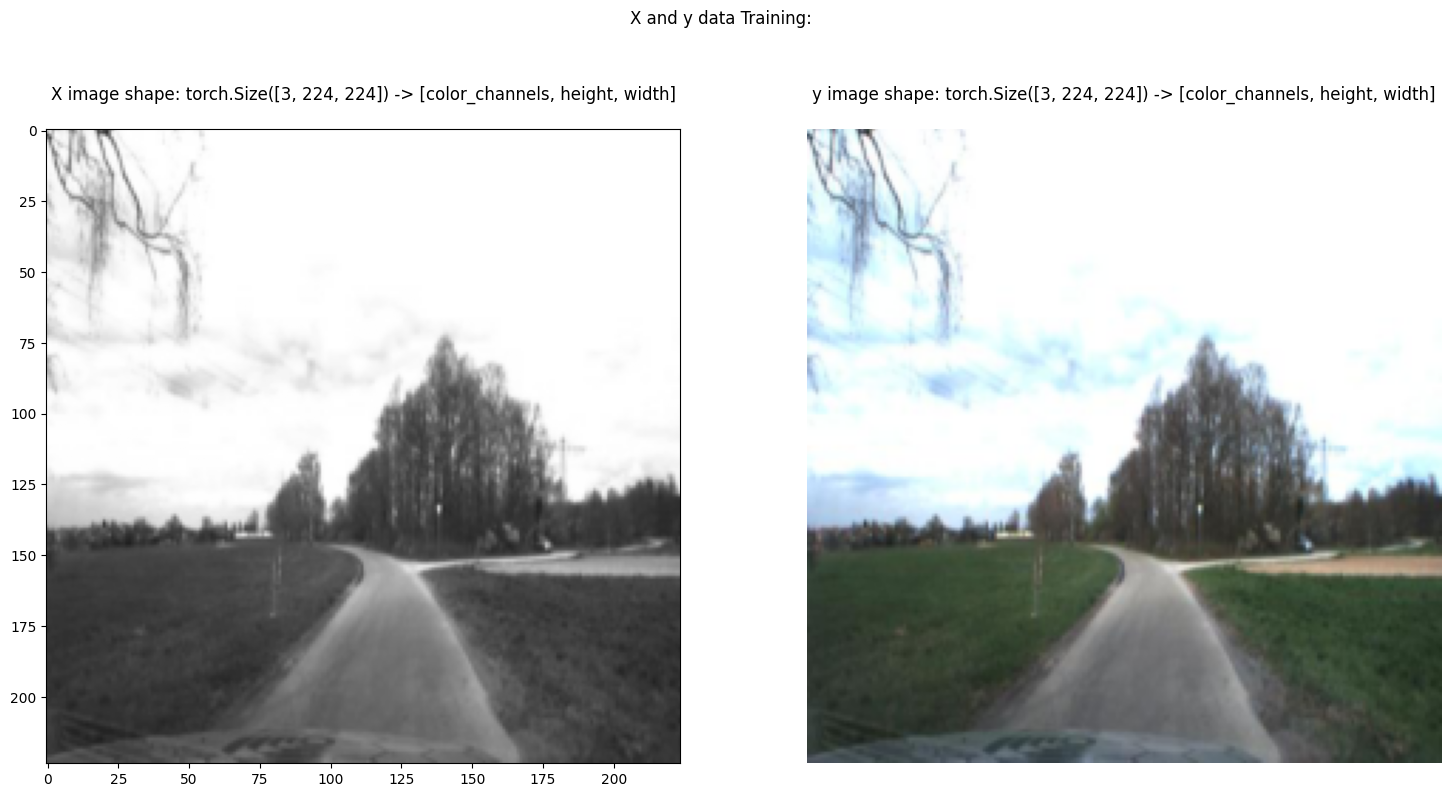

In [ ]:
# get dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))

# extract an image
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
train_img, train_label = (
    train_features_batch[random_idx],
    train_labels_batch[random_idx],
)

# plot image and label image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle("X and y data Training:")
ax1.imshow(train_img.permute(1, 2, 0))
ax2.imshow(train_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {train_img.shape} -> [color_channels, height, width]\n")
ax2.set_title(
    f"y image shape: {train_label.shape} -> [color_channels, height, width]\n",
)
plt.axis(False)

# image and Label shape after batching
print(
    f"Batch shape: {train_features_batch.shape} -> [batch_size, color_channels, height, width]",
)

Batch shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]


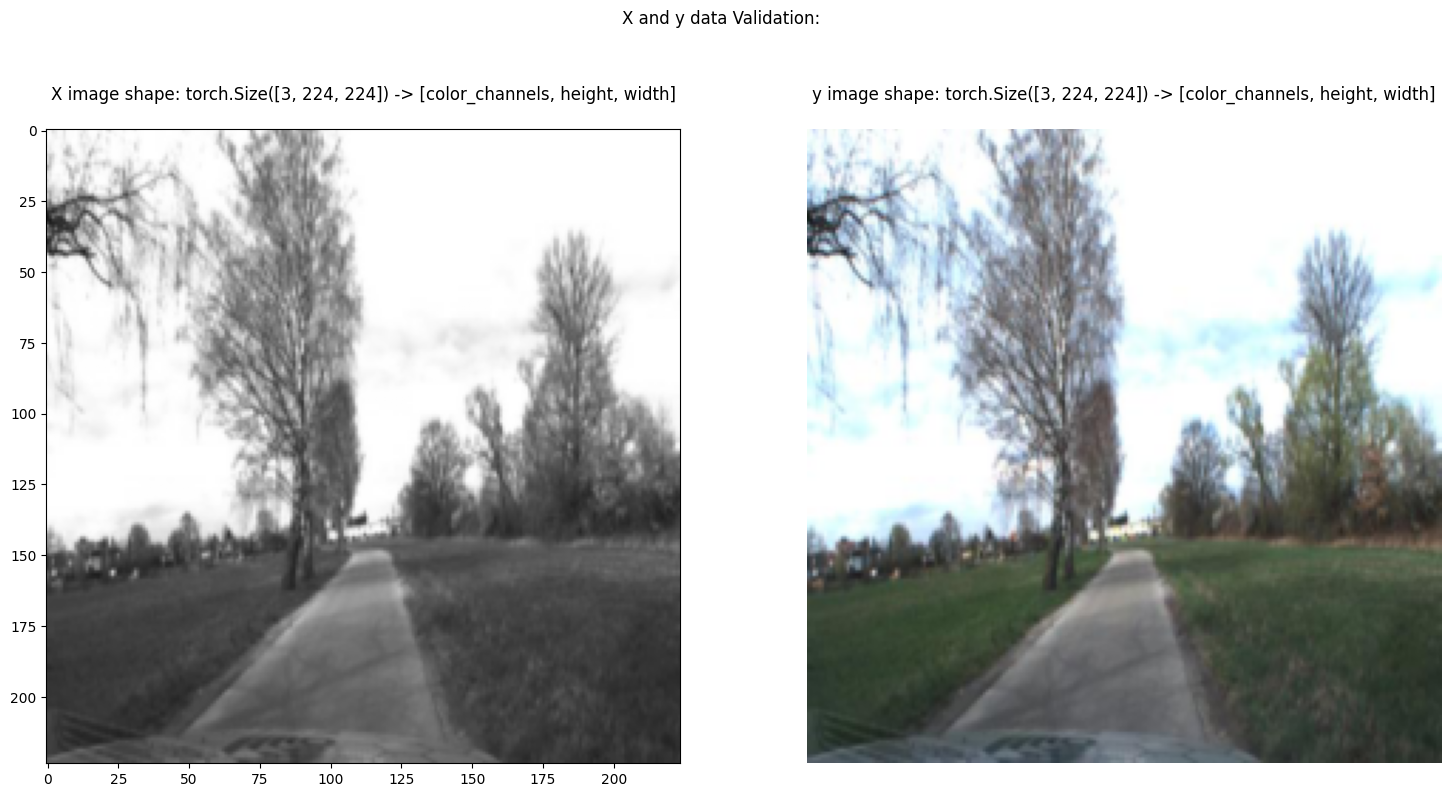

In [ ]:
# get dataloader
val_features_batch, val_labels_batch = next(iter(val_dataloader))

# extract an image
random_idx = torch.randint(0, len(val_features_batch), size=[1]).item()
val_img, val_label = val_features_batch[random_idx], val_labels_batch[random_idx]

# plot image and label image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle("X and y data Validation:")
ax1.imshow(val_img.permute(1, 2, 0))
ax2.imshow(val_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {val_img.shape} -> [color_channels, height, width]\n")
ax2.set_title(f"y image shape: {val_label.shape} -> [color_channels, height, width]\n")
plt.axis(False)

# image and Label shape after batching
print(
    f"Batch shape: {val_features_batch.shape} -> [batch_size, color_channels, height, width]",
)

Batch shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]


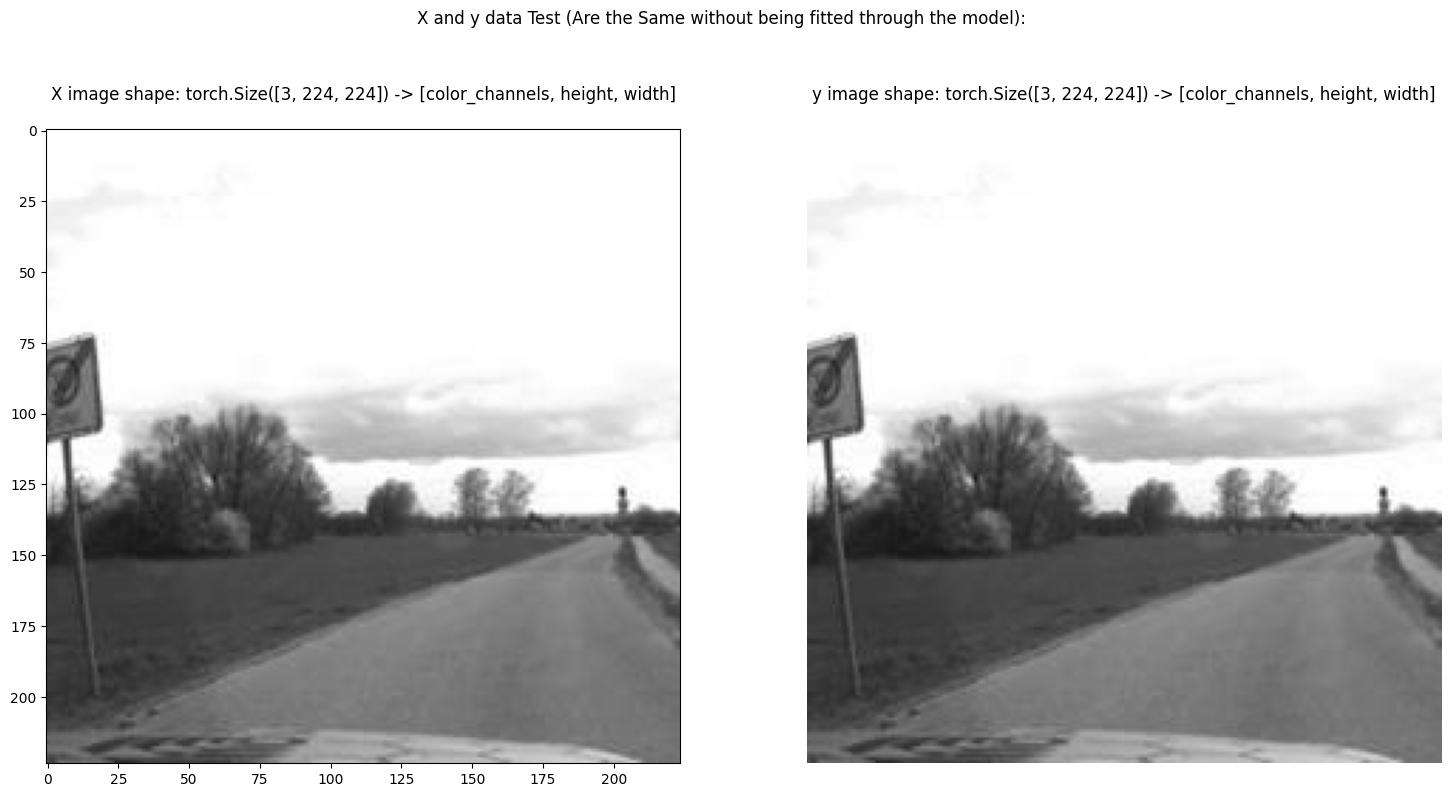

In [ ]:
# get dataloader
test_features_batch, test_labels_batch = next(iter(test_dataloader))

# extract an image
random_idx = 0
test_img, test_label = test_features_batch[random_idx], test_labels_batch[random_idx]

# plot image and label image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle("X and y data Test (Are the Same without being fitted through the model):")
ax1.imshow(test_img.permute(1, 2, 0))
ax2.imshow(test_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {test_img.shape} -> [color_channels, height, width]\n")
ax2.set_title(f"y image shape: {test_label.shape} -> [color_channels, height, width]\n")
plt.axis(False)

# image and Label shape after batching
print(
    f"Batch shape: {test_features_batch.shape} -> [batch_size, color_channels, height, width]",
)

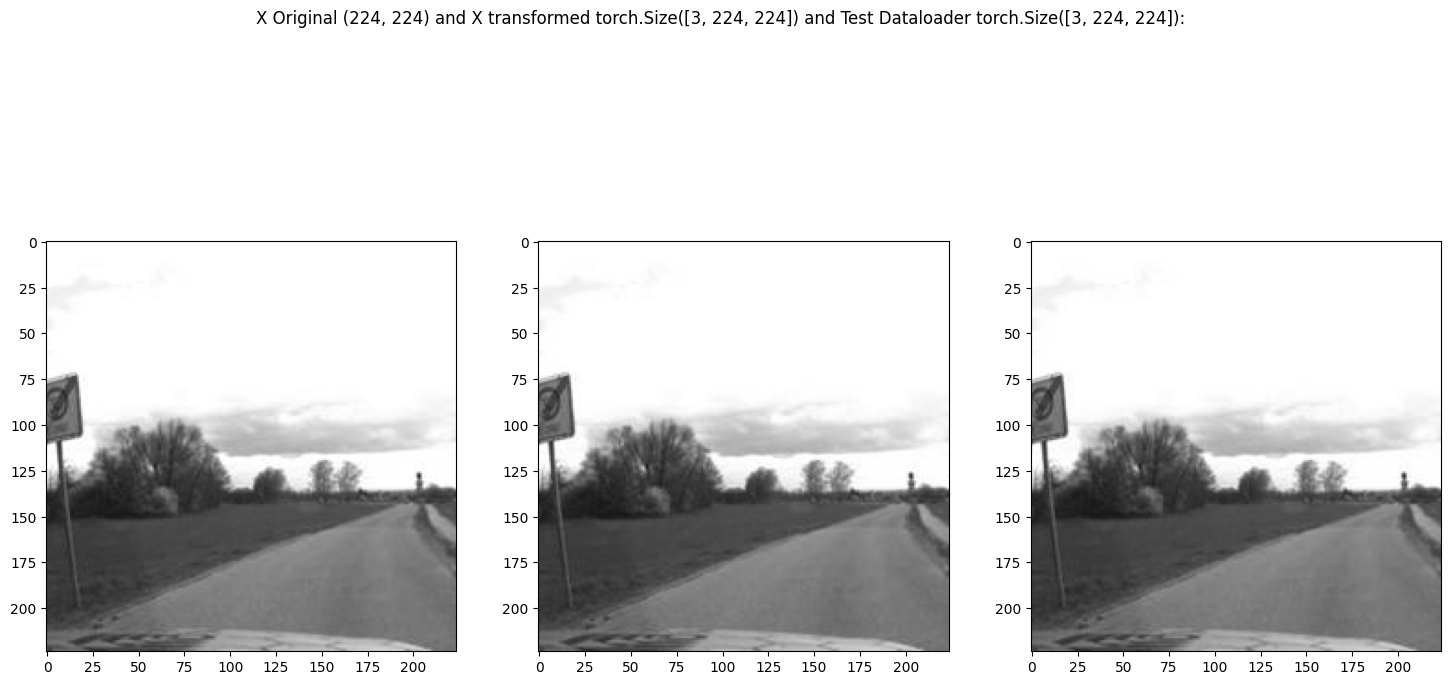

In [ ]:
# open and plot the image
with Image.open(PATH) as img:
    # plot image and label image
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
    fig.suptitle(
        f"X Original {img.size} and X transformed {transformed_image.shape} and Test Dataloader {test_img.shape}:",
    )
    ax1.imshow(img, cmap="gray", vmin=0, vmax=255)
    transformed_image = data_transform_test(img)
    ax2.imshow(transformed_image.permute(1, 2, 0))
    ax3.imshow(test_img.permute(1, 2, 0))

In [ ]:
# build the model (start with a baseline model and increase the complexity or use an exisiting model architecture)
class Encoder(nn.Module):
    """This is the Pytorch Downsample Encoder class. Since it inherits from nn.Module we have to override the forward() method"""

    def __init__(self, input_shape: int, output_shape: int):
        """Constructor Initialization. Calls the super constructor and initializes our model."""
        # call the super constructor
        super().__init__()

        # create the model
        self.block_1 = nn.Sequential(
            # 2 Convolution Layer
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=output_shape,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(output_shape),
            nn.Conv2d(
                in_channels=output_shape,
                out_channels=output_shape,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(output_shape),
            # activation fucntion
            nn.ReLU(),
        )

        # create the model
        self.block_2 = nn.Sequential(
            # downsample
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, X):
        """
        This function is mandatory in each pytorch model and calculates the foward pass.
        Note: to speed up the training time, don't reassign the values to X (memory intensive).

        :param X: tensor: The X data
        :return y: tensor: The y data (prediction)
        """
        X = self.block_1(X)

        # downsampling
        X_down = self.block_2(X)

        return X, X_down

In [ ]:
# build the model (start with a baseline model and increase the complexity or use an exisiting model architecture)
class Decoder(nn.Module):
    """This is the Pytorch Upsample Decoder class. Since it inherits from nn.Module we have to override the forward() method"""

    def __init__(self, input_shape: int, output_shape: int):
        """Constructor Initialization. Calls the super constructor and initializes our model."""
        # call the super constructor
        super().__init__()

        # create the model
        self.block_1 = nn.Sequential(
            # upsample
            nn.ConvTranspose2d(
                in_channels=input_shape,
                out_channels=output_shape,
                kernel_size=2,
                stride=2,
                padding=0,
            ),
        )

        # create the model
        self.block_2 = nn.Sequential(
            # 2 Convolution Layer
            nn.Conv2d(
                in_channels=output_shape * 2,
                out_channels=output_shape,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(output_shape),
            nn.Conv2d(
                in_channels=output_shape,
                out_channels=output_shape,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(output_shape),
            # activation fucntion
            nn.ReLU(),
        )

    def forward(self, X, X_skip):
        """
        This function is mandatory in each pytorch model and calculates the foward pass.
        Note: to speed up the training time, don't reassign the values to X (memory intensive).

        :param X: tensor: The X data
        :return y: tensor: The y data (prediction)
        """
        # Upsample
        X = self.block_1(X)

        # add propr information
        X = torch.cat([X, X_skip], axis=1)

        # compute output
        X = self.block_2(X)

        return X

In [ ]:
# build the model (start with a baseline model and increase the complexity or use an exisiting model architecture)
class UModel(nn.Module):
    """This is the Pytorch Model class. Since it inherits from nn.Module we have to override the forward() method"""

    def __init__(self, input_shape: int, output_shape: int):
        """Constructor Initialization. Calls the super constructor and initializes our model."""
        # call the super constructor
        super().__init__()

        # encoder
        self.encoder_1 = Encoder(input_shape, 64)
        self.encoder_2 = Encoder(64, 128)
        self.encoder_3 = Encoder(128, 256)
        self.encoder_4 = Encoder(256, 512)

        # bottleneck
        self.bottleneck = nn.Sequential(
            # 2 Convolution Layer
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            # activation fucntion
            nn.ReLU(),
        )

        # decoder
        self.decoder_1 = Decoder(1024, 512)
        self.decoder_2 = Decoder(512, 256)
        self.decoder_3 = Decoder(256, 128)
        self.decoder_4 = Decoder(128, 64)

        # classifier
        self.classifier = nn.Conv2d(64, output_shape, kernel_size=1, padding=0)

    def forward(self, X):
        """
        This function is mandatory in each pytorch model and calculates the foward pass.
        Note: to speed up the training time, don't reassign the values to X (memory intensive).

        :param X: tensor: The X data
        :return y: tensor: The y data (prediction)
        """
        # encoder
        X_1, X_down_1 = self.encoder_1(X)
        X_2, X_down_2 = self.encoder_2(X_down_1)
        X_3, X_down_3 = self.encoder_3(X_down_2)
        X_4, X_down_4 = self.encoder_4(X_down_3)

        # bottleneck
        X_5 = self.bottleneck(X_down_4)

        # decoder
        X_6 = self.decoder_1(X_5, X_4)
        X_7 = self.decoder_2(X_6, X_3)
        X_8 = self.decoder_3(X_7, X_2)
        X_9 = self.decoder_4(X_8, X_1)

        # classifier
        X_10 = self.classifier(X_9)

        return X_10

In [ ]:
# input shape (Image is without batch, so first of shape tupel)
input_shape = train_img.shape[0]

# output shape (Identical to input_shape)
output_shape = train_img.shape[0]

# Create a model instance of your own model
model = UModel(input_shape=input_shape, output_shape=output_shape).to(device)

# get the model
model.load_state_dict(torch.load("models/UModel.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

Text(0.5, 1.0, 'True image shape: torch.Size([3, 224, 224])\n')

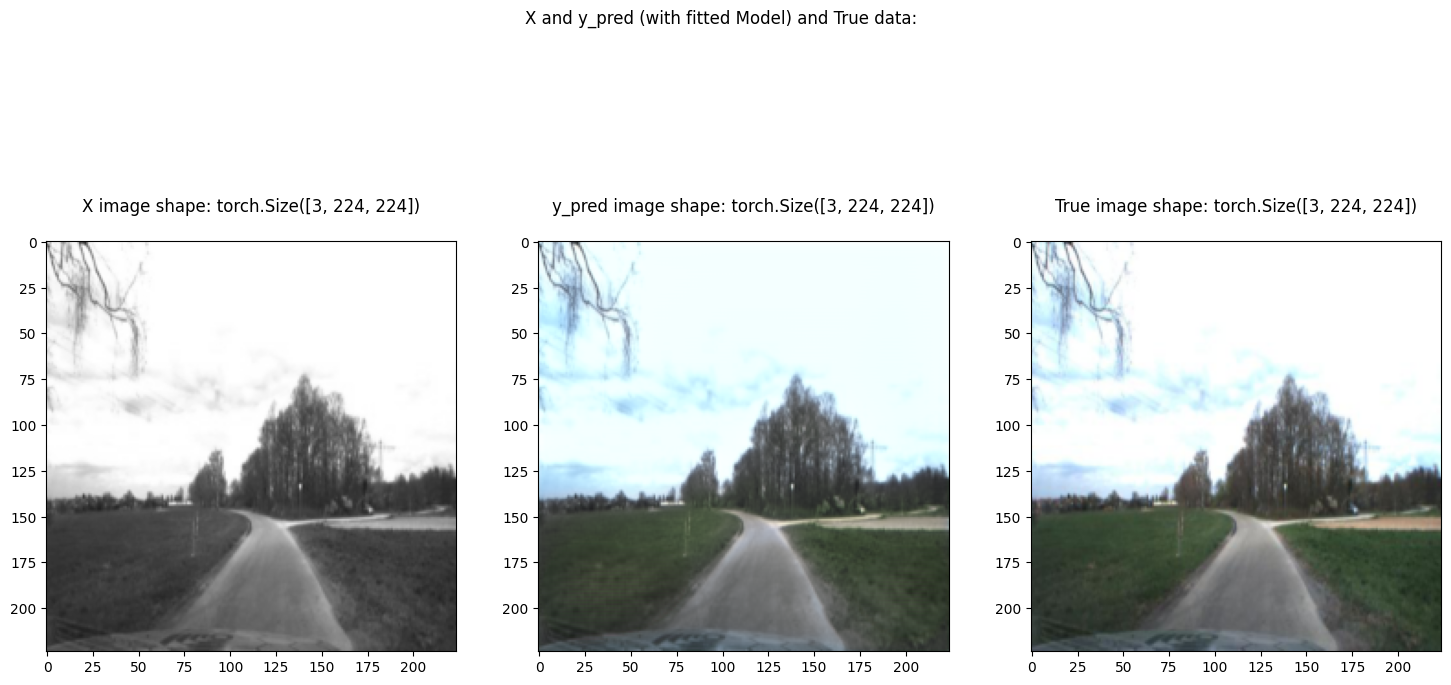

In [ ]:
# perform a forward pass on a single image in the train data
model.eval()
with torch.inference_mode():
    X_dummy = model(train_img.unsqueeze(dim=0).to(device))

# plot image model output and label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
fig.suptitle("X and y_pred (with fitted Model) and True data:")
ax1.imshow(train_img.permute(1, 2, 0))
ax2.imshow(X_dummy.cpu().squeeze().permute(1, 2, 0))
ax3.imshow(train_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {train_img.shape}\n")
ax2.set_title(f"y_pred image shape: {X_dummy.squeeze().shape}\n")
ax3.set_title(f"True image shape: {train_label.shape}\n")

Text(0.5, 1.0, 'True image shape: torch.Size([3, 224, 224])\n')

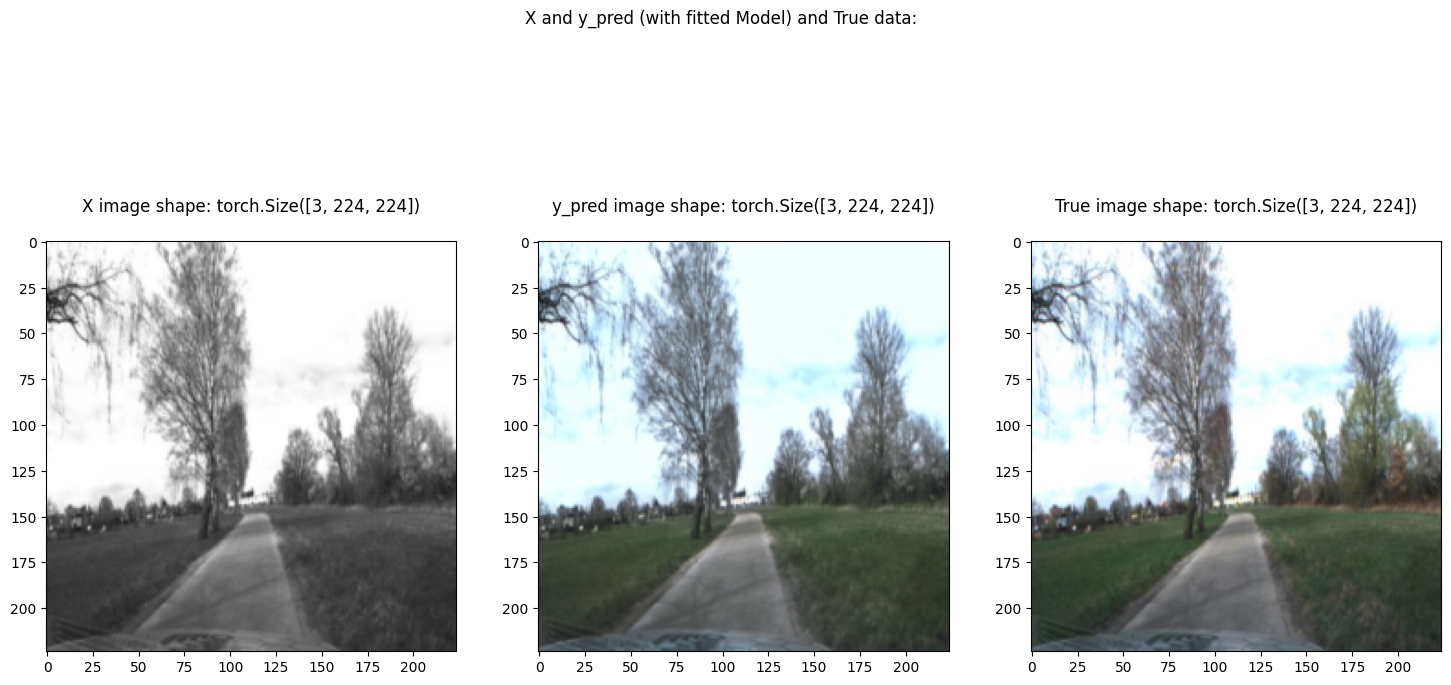

In [ ]:
# perform a forward pass on a single image in the val data
model.eval()
with torch.inference_mode():
    X_dummy = model(val_img.unsqueeze(dim=0).to(device))

# plot image model output and label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
fig.suptitle("X and y_pred (with fitted Model) and True data:")
ax1.imshow(val_img.permute(1, 2, 0))
ax2.imshow(X_dummy.cpu().squeeze().permute(1, 2, 0))
ax3.imshow(val_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {val_img.shape}\n")
ax2.set_title(f"y_pred image shape: {X_dummy.squeeze().shape}\n")
ax3.set_title(f"True image shape: {val_label.shape}\n")

Text(0.5, 1.0, 'y_pred image shape: torch.Size([3, 224, 224])\n')

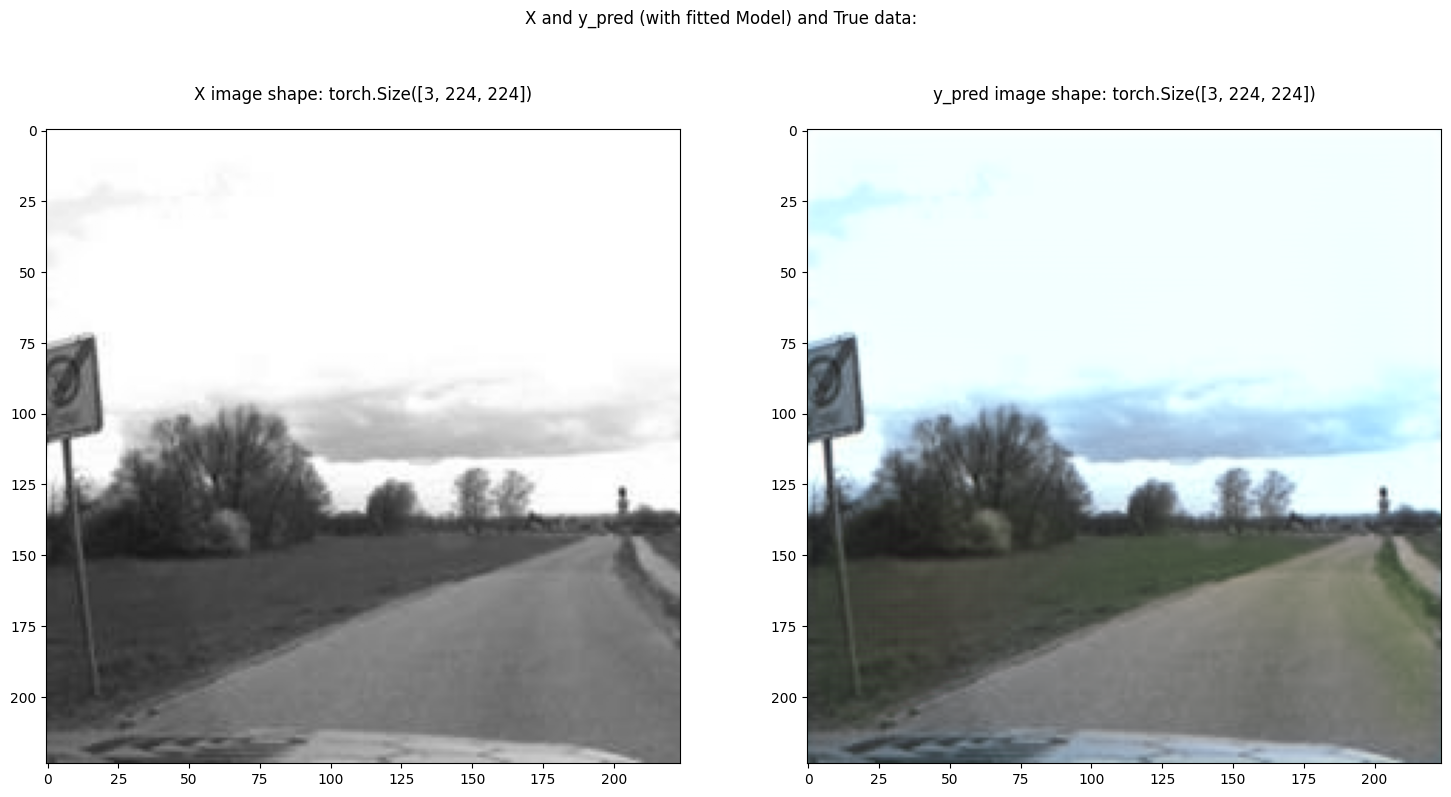

In [ ]:
# perform a forward pass on a single image in the test data
model.eval()
with torch.inference_mode():
    X_dummy = model(test_img.unsqueeze(dim=0).to(device))

# plot image model output and label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle("X and y_pred (with fitted Model) and True data:")
ax1.imshow(test_img.permute(1, 2, 0))
ax2.imshow(X_dummy.cpu().squeeze().permute(1, 2, 0))
ax1.set_title(f"X image shape: {test_img.shape}\n")
ax2.set_title(f"y_pred image shape: {X_dummy.squeeze().shape}\n")

In [ ]:
def make_predictions(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    device: torch.device = "cpu",
):
    """
    This function makes a prediction on the data X with the model.

    :param data_loader: torch.utils.data.DataLoader: Data to make a prediction on.
    :param model: object: Model to make a prediction with.
    :param device: string: Device to use. Defaults to "cpu".
    :return: pred_values: lists: Predictions and true value of the model.
    """
    # empy tensor to store values
    pred_values = torch.empty(size=(50, 3, 224, 224))

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode
    model.eval()

    # turn on inference mode
    with torch.inference_mode():
        # training: loop thorugh the training batches
        for batch, (X, y) in enumerate(data_loader):
            # put data on device
            X, y = X.to(device), y.to(device)

            # Make a prediction
            y_pred = model(X)

            # stack tensors
            pred_values[batch] = y_pred

    return pred_values

In [306]:
# make final predictions
y_pred_test = make_predictions(test_dataloader, model=model, device=device)

print(f"Shape of final Test Data: {y_pred_test.shape}")

Shape of final Test Data: torch.Size([50, 3, 224, 224])


In [307]:
# permute
y_pred_test = y_pred_test.permute(0, 2, 3, 1)
print(f"Shape of final Test Data: {y_pred_test.shape}")

Shape of final Test Data: torch.Size([50, 224, 224, 3])


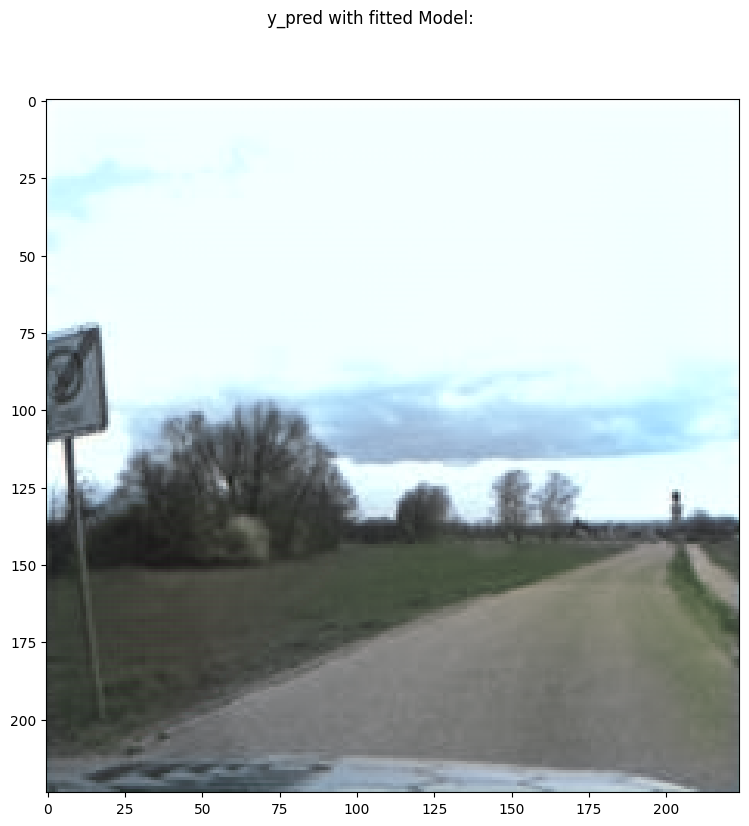

In [ ]:
test_img_final = y_pred_test[0]

# plot image model output and label
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 9))
fig.suptitle("y_pred with fitted Model:")
ax1.imshow(test_img_final)

In [309]:
# transform to numpy array
y_pred_test_numpy = y_pred_test.cpu().detach().numpy()
print(f"Shape of final Test Data: {y_pred_test_numpy.shape}")

Shape of final Test Data: (50, 224, 224, 3)


Shape of example Test Image: (224, 224, 3)


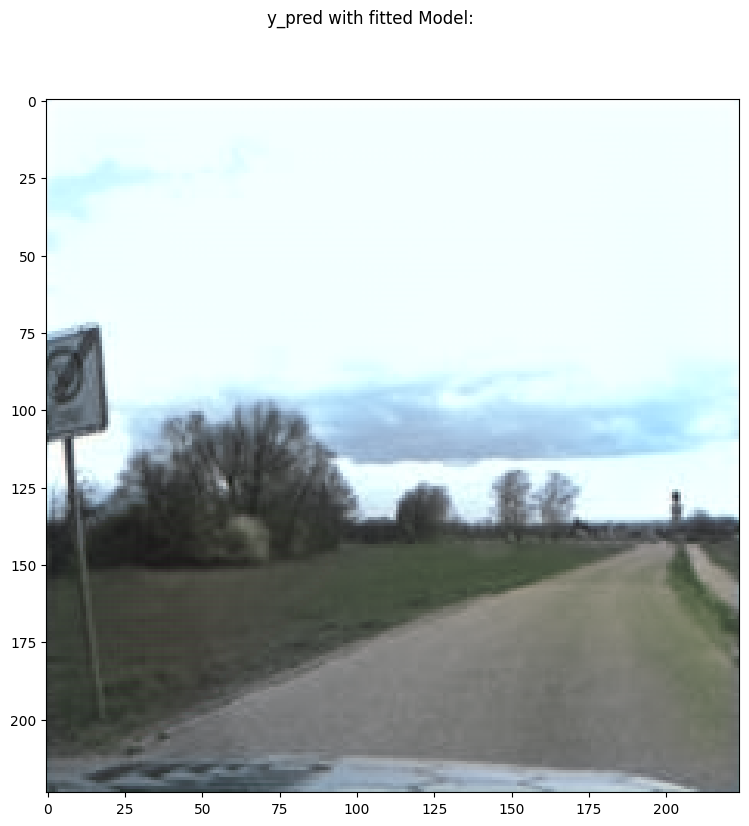

In [ ]:
test_img_final = y_pred_test_numpy[0]
print(f"Shape of example Test Image: {test_img_final.shape}")

# plot image model output and label
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 9))
fig.suptitle("y_pred with fitted Model:")
ax1.imshow(test_img_final)

In [ ]:
print(np.min(y_pred_test_numpy), np.max(y_pred_test_numpy))

# clip the array to [0-1]
y_pred_test_numpy_clipped = np.clip(y_pred_test_numpy, 0, 1)

print(np.min(y_pred_test_numpy_clipped), np.max(y_pred_test_numpy_clipped))

# scale from [0-1] to [0-255] and convert int to an integer
y_pred_test_numpy_clipped_255 = (y_pred_test_numpy_clipped * 255).astype("uint8")

print(np.min(y_pred_test_numpy_clipped_255), np.max(y_pred_test_numpy_clipped_255))

0.06450917 1.0759344
0.06450917 1.0
16 255


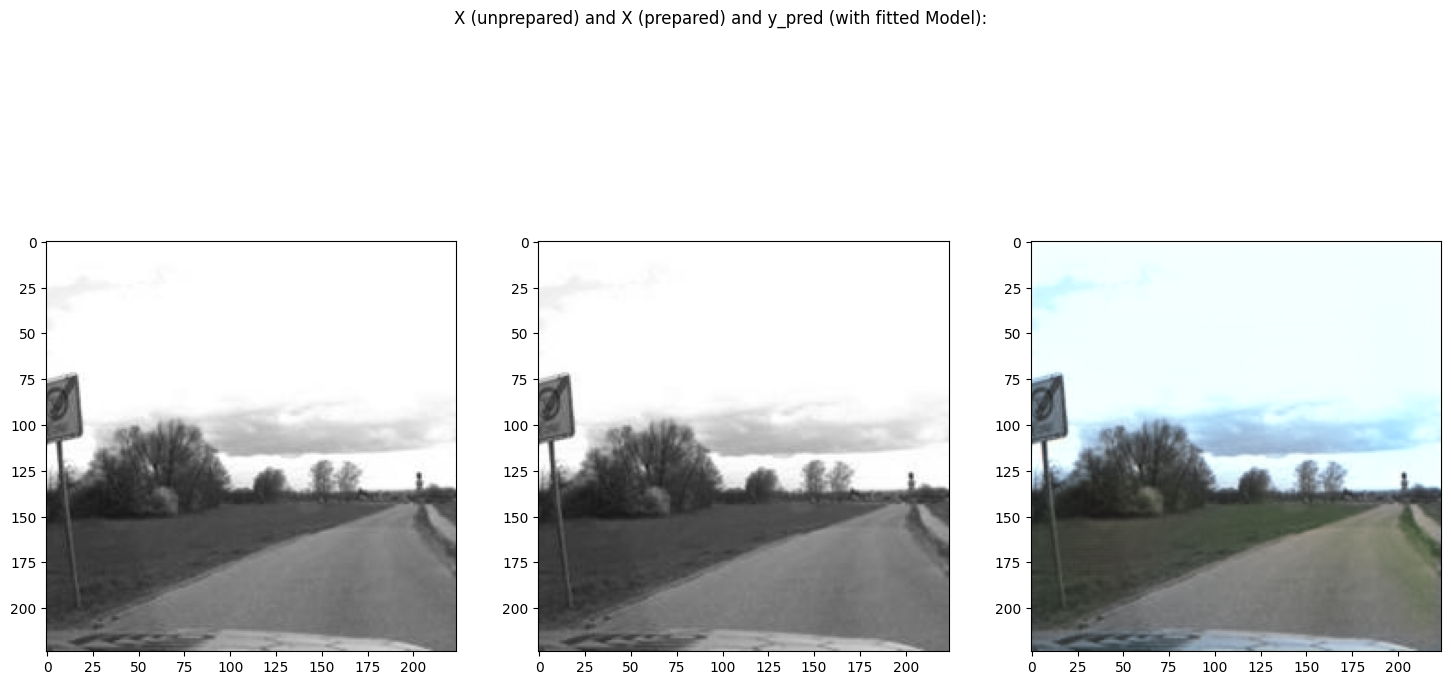

In [ ]:
# path original test image
PATH = "/content/data/ML2-Dataset/student_dataset/test_color/images/2_0000.jpg"
import matplotlib.image as mpimg


img = mpimg.imread(PATH)

test_img_final = y_pred_test_numpy_clipped_255[0]

# plot image model output and label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
fig.suptitle("X (unprepared) and X (prepared) and y_pred (with fitted Model):")
ax1.imshow(img, cmap="gray", vmin=0, vmax=255)
ax2.imshow(test_img.permute(1, 2, 0))
ax3.imshow(test_img_final)


In [313]:
# save to numy file
np.save("prediction.npy", y_pred_test_numpy_clipped_255)